# Yelp Restaurant Recommendation System 
(improving Yelp's recommendation system using sentiment analysis)

## Table of Contents
- [Introduction](#introduction)
- [Cleaning and Setup](#Cleaning-and-Setup)
- [Exploratory Data Analysis](#Exploratory-Data-Analysis)
- [Text Pre-Processing](#Text-Pre-Processing)

### Introduction
This project aims to try to improve Yelp's restaurant recommendation system by using sentiment analysis on customer reviews. By analyzing the text and user star ratings, we will predict user preferences and enhance the system's ability to recommend businesses based on the content of reviews. 

### Cleaning and Setup


In [3]:
import json
import pandas as pd

#import the file
review_file = "./data/yelp_academic_dataset_review.json"

#open json in read mode and read all lines from the file
with open(review_file, 'r', encoding='utf-8') as file:
    input_lines = file.readlines()

#parse through the json lines and make it into a python object
reviews = [json.loads(line) for line in input_lines]

#store into a pandas dataframe
reviews_df = pd.DataFrame(reviews)

#look at first few lines
reviews_df.head()


#Do the same for the business file
business_file = './data/yelp_academic_dataset_business.json'
with open(business_file, 'r', encoding='utf-8') as file1:
    input_lines = file1.readlines()
businesses = [json.loads(line) for line in input_lines]
businesses_df = pd.DataFrame(businesses)
businesses_df.head()


,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
0,Pns2l4eNsfO8kk83dixA6A,"Abby Rappoport, LAC, CMQ","1616 Chapala St, Ste 2",Santa Barbara,CA,93101,34.426679,-119.711197,5.0,7,0,{'ByAppointmentOnly': 'True'},"Doctors, Traditional Chinese Medicine, Naturop...",None
1,mpf3x-BjTdTEA3yCZrAYPw,The UPS Store,87 Grasso Plaza Shopping Center,Affton,MO,63123,38.551126,-90.335695,3.0,15,1,{'BusinessAcceptsCreditCards': 'True'},"Shipping Centers, Local Services, Notaries, Ma...","{'Monday': '0:0-0:0', 'Tuesday': '8:0-18:30', ..."
2,tUFrWirKiKi_TAnsVWINQQ,Target,5255 E Broadway Blvd,Tucson,AZ,85711,32.223236,-110.880452,3.5,22,0,"{'BikeParking': 'True', 'BusinessAcceptsCredit...","Department Stores, Shopping, Fashion, Home & G...","{'Monday': '8:0-22:0', 'Tuesday': '8:0-22:0', ..."
3,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,PA,19107,39.955505,-75.155564,4.0,80,1,"{'RestaurantsDelivery': 'False', 'OutdoorSeati...","Restaurants, Food, Bubble Tea, Coffee & Tea, B...","{'Monday': '7:0-20:0', 'Tuesday': '7:0-20:0', ..."
4,mWMc6_wTdE0EUBKIGXDVfA,Perkiomen Valley Brewery,101 Walnut St,Green Lane,PA,18054,40.338183,-75.471659,4.5,13,1,"{'BusinessAcceptsCreditCards': 'True', 'Wheelc...","Brewpubs, Breweries, Food","{'Wednesday': '14:0-22:0', 'Thursday': '16:0-2..."


The dataset that Yelp provided has many businesses, many of which are not restaurants. I thus will filter only the businesses that have categories labeled as 'resturant'.


In [4]:
#restaurants_df will hold the businesses
#restaurants_reviews_df will hold the reviews
restaurants_df = businesses_df[businesses_df['categories'].str.contains('Restaurants', na=False)]
restaurants_reviews_df = reviews_df[reviews_df['business_id'].isin(restaurants_df['business_id'])]
restaurants_df.head()
restaurants_reviews_df.head()

,review_id,user_id,business_id,stars,useful,funny,cool,text,date
0,KU_O5udG6zpxOg-VcAEodg,mh_-eMZ6K5RLWhZyISBhwA,XQfwVwDr-v0ZS3_CbbE5Xw,3.0,0,0,0,"If you decide to eat here, just be aware it is...",2018-07-07 22:09:11
2,saUsX_uimxRlCVr67Z4Jig,8g_iMtfSiwikVnbP2etR0A,YjUWPpI6HXG530lwP-fb2A,3.0,0,0,0,Family diner. Had the buffet. Eclectic assortm...,2014-02-05 20:30:30
3,AqPFMleE6RsU23_auESxiA,_7bHUi9Uuf5__HHc_Q8guQ,kxX2SOes4o-D3ZQBkiMRfA,5.0,1,0,1,"Wow! Yummy, different, delicious. Our favo...",2015-01-04 00:01:03
4,Sx8TMOWLNuJBWer-0pcmoA,bcjbaE6dDog4jkNY91ncLQ,e4Vwtrqf-wpJfwesgvdgxQ,4.0,1,0,1,Cute interior and owner (?) gave us tour of up...,2017-01-14 20:54:15
5,JrIxlS1TzJ-iCu79ul40cQ,eUta8W_HdHMXPzLBBZhL1A,04UD14gamNjLY0IDYVhHJg,1.0,1,2,1,I am a long term frequent customer of this est...,2015-09-23 23:10:31


In [5]:
#check for any sort of missing values
restaurants_df.isna().sum()
restaurants_reviews_df.isna().sum()

review_id      0
user_id        0
business_id    0
stars          0
useful         0
funny          0
cool           0
text           0
date           0
dtype: int64

### Exploratory Data Analysis

The yelp dataset contains 6,990,280 reviews across 150,346 businesses. We will be looking at the distribution of star ratings as well as the relationships between ratings and reviews.

In [6]:
import seaborn as sns 
import matplotlib.pyplot as plt

#mean and median number of reviews
mean_reviews = restaurants_df['review_count'].mean()
median_reviews = restaurants_df['review_count'].median()

#the average star rating of a restaurant
average_star_rating = restaurants_df['stars'].mean()

print(f"Mean number of reviews: {mean_reviews}")
print(f"Median number of reviews: {median_reviews}")
print(f"Average star rating: {average_star_rating}")


Mean number of reviews: 87.26714241983623
Median number of reviews: 33.0
Average star rating: 3.5151718068416624


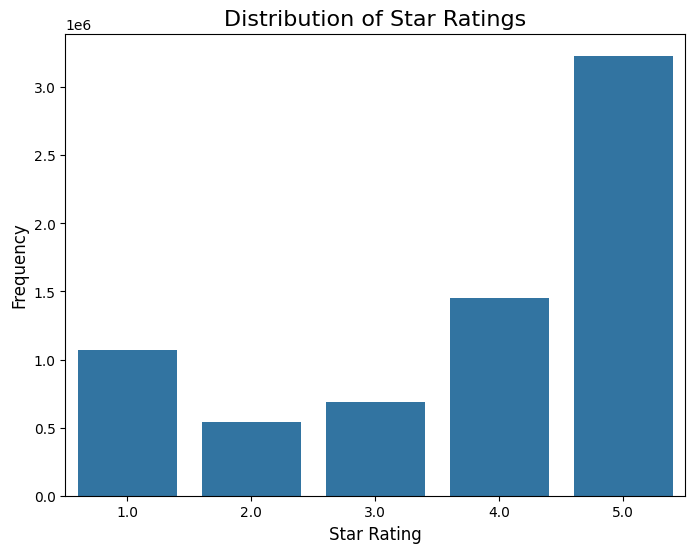

In [7]:
#distribution plot of star ratings
plt.figure(figsize=(8,6))
sns.countplot(x='stars', data=reviews_df)

#adding titles and labels
plt.title('Distribution of Star Ratings', fontsize=16)
plt.xlabel('Star Rating', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.show()

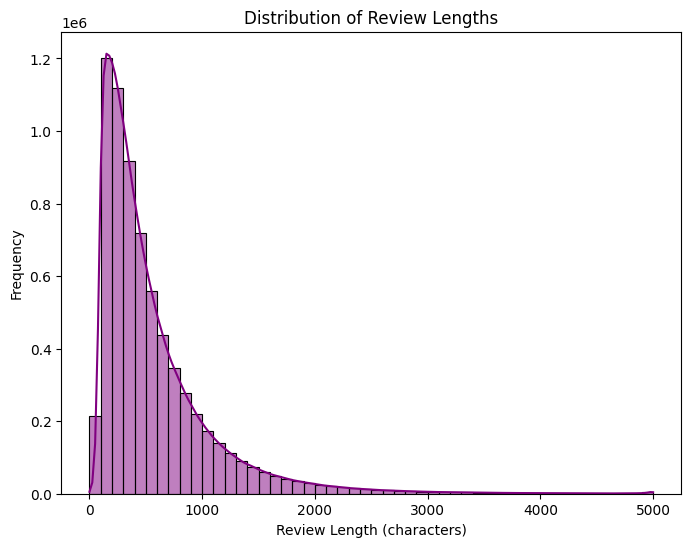

In [8]:
#Review Length Analysis
reviews_df['review_length'] = reviews_df['text'].apply(len)
plt.figure(figsize=(8,6))
sns.histplot(reviews_df['review_length'], bins=50, kde=True, color='purple')
plt.title('Distribution of Review Lengths')
plt.xlabel('Review Length (characters)')
plt.ylabel('Frequency')
plt.show()

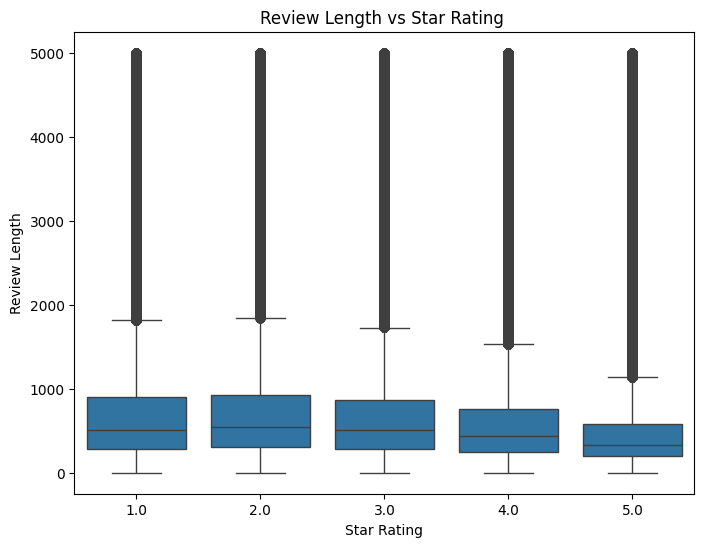

In [9]:
#Correlation between stars and review length
plt.figure(figsize=(8,6))
sns.boxplot(x='stars', y='review_length', data=reviews_df)
plt.title('Review Length vs Star Rating ')
plt.xlabel('Star Rating')
plt.ylabel('Review Length')
plt.show()

### Text Pre-Processing

In [10]:
#remove some stop words from reviews
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
print(stopwords.words('english'))


['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\matth\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [11]:
stop_words = set(stopwords.words('english'))

# Apply transformations: remove stop words, convert to lowercase, and remove punctuation
restaurants_reviews_df['text'] = restaurants_reviews_df['text'].apply(
    lambda x: ' '.join(
        word for word in x.lower().split() if word not in stop_words
    )
)

# Remove punctuation using pandas' .str.replace() with regex
restaurants_reviews_df['text'] = restaurants_reviews_df['text'].str.replace(r'[^\w\s]', '', regex=True)

#save csv 
restaurants_reviews_df.to_csv('cleaned_reviews.csv', index=False)

C:\Users\matth\AppData\Local\Temp\ipykernel_10736\4067480815.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restaurants_reviews_df['text'] = restaurants_reviews_df['text'].apply(
C:\Users\matth\AppData\Local\Temp\ipykernel_10736\4067480815.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restaurants_reviews_df['text'] = restaurants_reviews_df['text'].str.replace(r'[^\w\s]', '', regex=True)


In [12]:
#stemming
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer

#make stemmer
stemmer = PorterStemmer()

#tokenize text
def stem_text(text):
    words = word_tokenize(text)
    stemmed_words = [stemmer.stem(word) for word in words]
    return ' '.join(stemmed_words)

print(restaurants_reviews_df.head())

                review_id                 user_id             business_id  \
0  KU_O5udG6zpxOg-VcAEodg  mh_-eMZ6K5RLWhZyISBhwA  XQfwVwDr-v0ZS3_CbbE5Xw   
2  saUsX_uimxRlCVr67Z4Jig  8g_iMtfSiwikVnbP2etR0A  YjUWPpI6HXG530lwP-fb2A   
3  AqPFMleE6RsU23_auESxiA  _7bHUi9Uuf5__HHc_Q8guQ  kxX2SOes4o-D3ZQBkiMRfA   
4  Sx8TMOWLNuJBWer-0pcmoA  bcjbaE6dDog4jkNY91ncLQ  e4Vwtrqf-wpJfwesgvdgxQ   
5  JrIxlS1TzJ-iCu79ul40cQ  eUta8W_HdHMXPzLBBZhL1A  04UD14gamNjLY0IDYVhHJg   

   stars  useful  funny  cool  \
0    3.0       0      0     0   
2    3.0       0      0     0   
3    5.0       1      0     1   
4    4.0       1      0     1   
5    1.0       1      2     1   

                                                text                 date  
0  decide eat here aware going take 2 hours begin...  2018-07-07 22:09:11  
2  family diner buffet eclectic assortment large ...  2014-02-05 20:30:30  
3  wow yummy different delicious favorite lamb cu...  2015-01-04 00:01:03  
4  cute interior owner  gave us to

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\matth\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [1]:
#most common words
from wordcloud import WordCloud
text = " ".join(review for review in restaurants_reviews_df['text'])
#make the cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

plt.figure(figsize=(10,6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

NameError: name 'restaurants_reviews_df' is not defined